# Step 1: Pre-processing model and reanalsyis data

---

## Instructions for activating the Jupyter kernel for the `cmip6hack-multigen` conda environment

In a Jupyterlab terminal, navigate to the `/cmip6hack-multigen/` folder and run the command:
```bash
source spinup_env.sh
```
which will create the `cmip6hack-multigen` conda environment and install it as a python kernel for jupyter.

Then, switch the kernel (drop-down menu in the top right hand corner) to cmip6hack-multigen and restart the notebook.

### Pre-process climate model output in GCS

This notebook uses [`intake-esm`](https://intake-esm.readthedocs.io/en/latest/) to ingest and organize climate model output from various model generations and resave their time-mean fields locally.

In [34]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [35]:
import os
import sys
import numpy as np
import pandas as pd
import xarray as xr
import xskillscore as xs
import xesmf as xe
from tqdm.autonotebook import tqdm  # Fancy progress bars for our loops!
import intake

import matplotlib.pyplot as plt

# util.py is in the local directory
# it contains code that is common across project notebooks
# or routines that are too extensive and might otherwise clutter
# the notebook design
import util
import preprocess as pp
import qc

import warnings

interim_path = "../data/interim/"

In [36]:
varnames = ['tas', 'pr', 'psl']
timeslice = slice('1981', '2010')
coarsen_size = 2

In [37]:
mips = ["cmip6"]

In [ ]:
ens_dict = {}
ens_dict = pp.load_ensembles(varnames, timeslice=timeslice, mip_ids=mips)

processed = {}
for key in ens_dict.keys():
    processed[key] = []

In [7]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore", category=RuntimeWarning)
    for key, ens in tqdm(ens_dict.items()):
        mean = ens.mean(dim=['time'], keep_attrs=True, skipna=True)
        rename_mean = dict([ (dv, dv+"_mean") for dv in mean.data_vars])
        processed[key].append(mean.rename(rename_mean))

## Pre-process observational data products

In [5]:
era5 = pp.load_era("../data/raw/reanalysis/ERA5_mon_2d.nc", timeslice=timeslice, coarsen_size=2).chunk({'time': -1})

In [6]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore", category=RuntimeWarning)
    
    era_mean = era5.mean(dim=['time'], keep_attrs=True, skipna=True)
    rename_mean = dict([ (dv, dv+"_mean") for dv in era_mean.data_vars])
    era_mean = era_mean.rename(rename_mean)

### Make plot

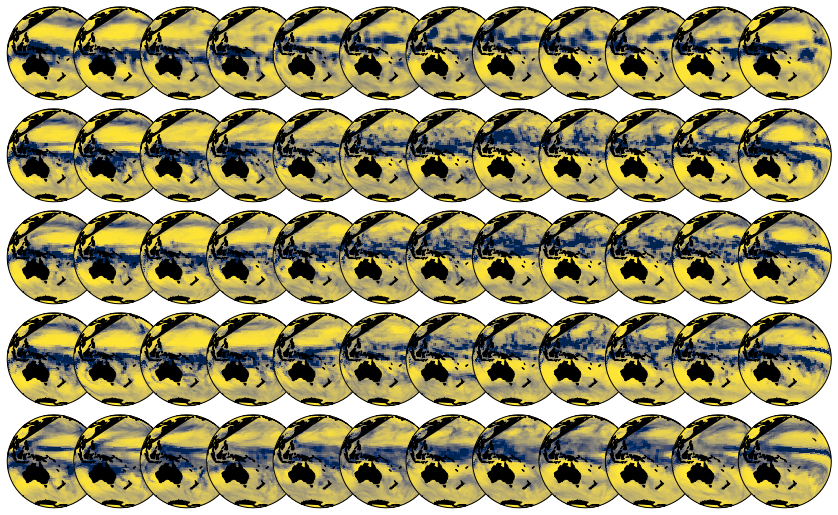

In [26]:
ne = 5
nt = 12

plt.figure(figsize=(12, 8.5))

for e in range(ne):
    for t in range(nt):
        pr = ens['pr'].isel(ensemble=e, time=t)
        
        ax = plt.axes([t/(nt+1.), e/(ne+1), 1.75/(nt+1), 1.75/(ne+1)], projection=ortho)
        q = pr.plot(vmin=0., vmax=1.5e-4, transform = geo, cmap="cividis_r")
        ax.add_feature(cartopy.feature.COASTLINE, edgecolor="k")
        ax.add_feature(cartopy.feature.BORDERS, linestyle='-', edgecolor="k")
        q.colorbar.remove()
        plt.title("")
        
plt.savefig(f"../figures/schematic_globe_ens.png",bbox_inches='tight',dpi=200, transparent=True)

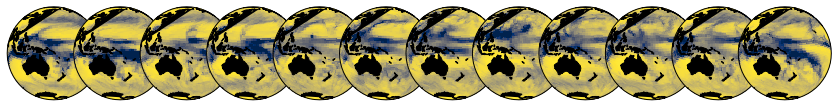

In [28]:
plt.figure(figsize=(12, 2))

for t in range(nt):
    pr = era5['pr'].isel(time=t)

    ax = plt.axes([t/(nt+1.), 0, 1.75/(nt+1), 1.], projection=ortho)
    q = pr.plot(vmin=0., vmax=1.5e-4, transform = geo, cmap="cividis_r")
    ax.add_feature(cartopy.feature.COASTLINE, edgecolor="k")
    ax.add_feature(cartopy.feature.BORDERS, linestyle='-', edgecolor="k")
    q.colorbar.remove()
    plt.title("")
        
plt.savefig(f"../figures/schematic_globe_obs.png",bbox_inches='tight',dpi=200, transparent=True)

In [8]:
era_mean

<xarray.Dataset>
Dimensions:   (lat: 90, lon: 180)
Coordinates:
  * lon       (lon) float64 1.0 3.0 5.0 7.0 9.0 ... 353.0 355.0 357.0 359.0
  * lat       (lat) float64 -89.0 -87.0 -85.0 -83.0 ... 83.0 85.0 87.0 89.0
Data variables:
    psl_mean  (lat, lon) float64 dask.array<chunksize=(90, 180), meta=np.ndarray>
    tas_mean  (lat, lon) float64 dask.array<chunksize=(90, 180), meta=np.ndarray>
    pr_mean   (lat, lon) float64 dask.array<chunksize=(90, 180), meta=np.ndarray>

In [ ]:
pr = era5['pr']

ax = plt.axes([0, 0, 1, 1.], projection=ortho)
q = pr.plot(vmin=0., vmax=1.5e-4, transform = geo, cmap="cividis_r")
ax.add_feature(cartopy.feature.COASTLINE, edgecolor="k")
ax.add_feature(cartopy.feature.BORDERS, linestyle='-', edgecolor="k")
q.colorbar.remove()
plt.title("")
        
plt.savefig(f"../figures/schematic_globe_obs-mean.png",bbox_inches='tight',dpi=200, transparent=True)

In [22]:
import cartopy
import cartopy.crs as ccrs
ortho = ccrs.Orthographic(-50, 20) # define target coordinate frame
geo = ccrs.PlateCarree() # define origin coordinate frame

vmin = 0.; vmax=1.5e-4

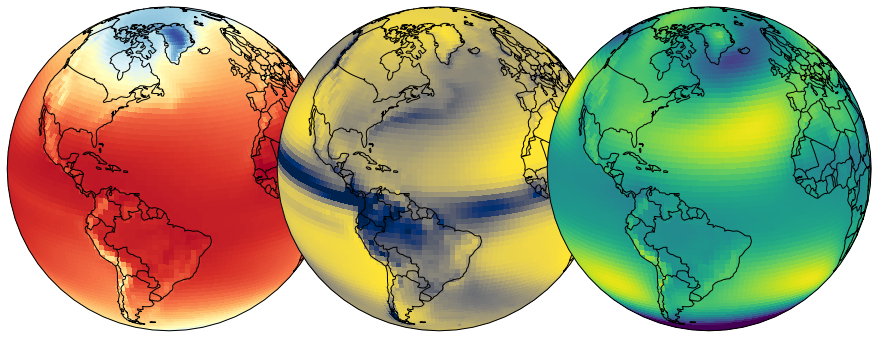

In [33]:
plt.figure(figsize=(15, 4.5))

cmaps = ["RdYlBu_r", "cividis_r", "viridis"]
clims = [[273-30, 273+30], [0., 1.e-4], [100000,102250]]

ne = len(varnames)
for e, var in enumerate(varnames):
    v = era_mean[var+"_mean"]

    ax = plt.axes([e/(ne+1), 0, 1.75/(ne+1),  1], projection=ortho)
    q = v.plot(transform = geo, cmap=cmaps[e])
    q.set_clim(clims[e])
    ax.add_feature(cartopy.feature.COASTLINE, edgecolor="k")
    ax.add_feature(cartopy.feature.BORDERS, linestyle='-', edgecolor="k")
    q.colorbar.remove()
    plt.title("")
        
plt.savefig(f"../figures/schematic_globe_era-vars.png",bbox_inches='tight',dpi=200, transparent=True)